# Курсовой проект

Задание для курсового проекта:

Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

Ник на kaggle: Ira Soloveva

* [1. Загрузка данных](#load)
* [2. EDA](#eda)
* [3. Обработка выбросов](#outlier)
* [4. Обработка пропусков](#nan)
* [5. Построение новых признаков](#new_features)
* [6. Отбор признаков](#features)
* [7. Разбиение на train и test](#split)
* [8. Построение модели](#model)
* [9. Прогнозирование на тестовом датасете](#test)

#### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import mode

import seaborn as sns
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Пути к файлам

In [4]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### 1. Загрузка данных<a class='anchor' id='load'>

#### Описание датасета

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [6]:
train_df.shape

(10000, 20)

In [7]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [9]:
test_df.shape

(5000, 19)

In [10]:
train_df.shape[1] - 1 == test_df.shape[1]

True

#### Приведение типов

In [11]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [12]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [13]:
train_df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### 2. EDA<a class='anchor' id='eda'>

Делаем EDA для:

* Исправления выбросов
* Заполнения NaN
* Идей для генерации новых фич

#### Целевая переменная

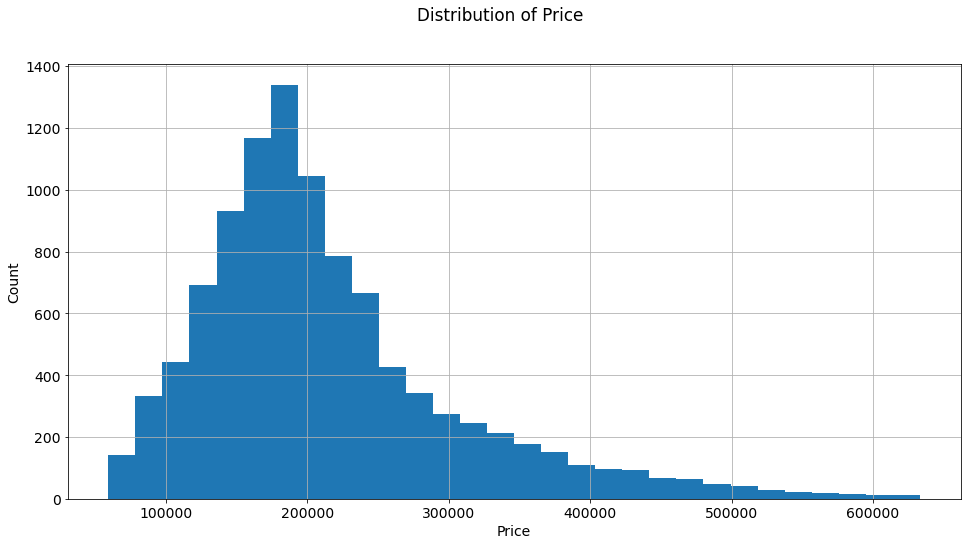

In [14]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

#### Количественные переменные

In [15]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,1.908300e+04


In [16]:
medians = train_df.median()

Исходя из подсчета статистик можно сделать вывод, что: 
1. в признаках LifeSquare и Healthcare_1 есть пропуски,
2. признаки Rooms, KitchenSquare, HouseFloor имеют нулевые значения,
3. признаки Square, LifeSquare, KitchenSquare, HouseYear имеют экстремально низкие или высокие значения,
4. признаки Ecology_1, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1 сложно оценить на адекватность, т.к. нет понимания, какую информацию несут в себе данные признаки

#### Номинативные переменные

In [17]:
train_df.select_dtypes(include='object').describe()

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000,10000,10000
unique,10000,205,2,2,2
top,4137,27,B,B,B
freq,1,851,9903,9725,9175


In [18]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
209      1
207      1
199      1
205      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [19]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [20]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [21]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 3. Обработка выбросов<a class='anchor' id='outlier'>

#### Rooms

In [22]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Количество 

In [23]:
train_df[train_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798


In [24]:
train_df[train_df['Rooms'] > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
8794,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416


In [25]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 5), 'Rooms_outlier'] = 1

In [26]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] > 5, 'Rooms'] = medians['Rooms']

In [27]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### Floor, HouseFloor

In [28]:
train_df['Floor'].value_counts()

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
33      1
37      1
31      1
Name: Floor, dtype: int64

In [29]:
train_df['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
32.0        4
37.0        4
28.0        3
99.0        2
48.0        2
39.0        2
44.0        1
36.0        1
26.0        1
45.0        1
29.0        1
38.0        1
47.0        1
117.0       1
31.0        1
Name: HouseFloor, dtype: int64

In [30]:
train_df[train_df['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,135466.559958,0
152,12947,53,2.0,56.023342,NaN,0.0,14,0.0,1977,0.049637,...,B,34,7759,0,229.0,1,3,B,247074.564832,0
159,13146,74,1.0,46.449711,NaN,0.0,6,0.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,168705.450148,0
186,12174,62,1.0,44.954880,NaN,0.0,8,0.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,133773.301722,0
229,15661,45,3.0,81.094922,NaN,0.0,15,0.0,1977,0.195781,...,B,23,5212,6,NaN,3,2,B,442472.456032,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,629,27,1.0,42.936724,NaN,0.0,2,0.0,1977,0.011654,...,B,4,915,0,NaN,0,0,B,129674.841139,0
9931,15686,1,1.0,47.402412,NaN,0.0,14,0.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,174740.301224,0
9940,4711,6,1.0,41.224118,NaN,0.0,8,0.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,125612.639104,0
9950,5383,48,3.0,98.994909,NaN,0.0,3,0.0,1977,0.041125,...,B,46,9515,5,NaN,1,10,B,418817.004446,0


In [31]:
train_df[train_df['Floor'] > train_df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,...,A,26,4439,1,1130.0,1,5,B,186971.926566,0
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,...,B,23,5212,6,NaN,3,2,B,250466.980777,0
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,...,B,37,7687,11,176.0,5,5,B,366916.246494,0
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,135466.559958,0
25,4521,6,2.0,65.409965,NaN,1.0,18,1.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,191205.272608,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,...,B,46,9515,5,NaN,1,10,B,524365.550705,0
9968,9920,1,3.0,86.487550,NaN,1.0,18,17.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,248248.935528,0
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,114878.830713,0
9975,4944,6,2.0,52.573133,NaN,1.0,18,17.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,154366.031184,0


In [32]:
train_df[(train_df['Floor'] > train_df['HouseFloor']) & (train_df['HouseFloor'] > 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,...,A,26,4439,1,1130.0,1,5,B,186971.926566,0
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,...,B,23,5212,6,NaN,3,2,B,250466.980777,0
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,...,B,37,7687,11,176.0,5,5,B,366916.246494,0
25,4521,6,2.0,65.409965,NaN,1.0,18,1.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,191205.272608,0
26,8553,88,3.0,83.262530,4.769174,1.0,13,1.0,1977,0.127376,...,B,43,8429,3,NaN,3,9,B,410883.892020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9953,7659,57,1.0,38.485252,22.550608,8.0,19,17.0,1992,0.133215,...,B,49,11395,3,1406.0,3,4,A,183485.284995,0
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,...,B,46,9515,5,NaN,1,10,B,524365.550705,0
9968,9920,1,3.0,86.487550,NaN,1.0,18,17.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,248248.935528,0
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,114878.830713,0


In [33]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1

In [34]:
Floor_swap = (train_df['Floor'] > train_df['HouseFloor']) & (train_df['HouseFloor'] > 0)
train_df.loc[Floor_swap, ['Floor','HouseFloor']] = train_df.loc[Floor_swap, ['HouseFloor','Floor']].values

In [35]:
train_df[train_df['Floor'] > train_df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier
24,4717,27,1.0,44.203947,NaN,0.0,2.0,0.0,1977,0.072158,...,2,629,1,NaN,0,0,A,135466.559958,0,1
152,12947,53,2.0,56.023342,NaN,0.0,14.0,0.0,1977,0.049637,...,34,7759,0,229.0,1,3,B,247074.564832,0,1
159,13146,74,1.0,46.449711,NaN,0.0,6.0,0.0,1977,0.075779,...,6,1437,3,NaN,0,2,B,168705.450148,0,1
186,12174,62,1.0,44.954880,NaN,0.0,8.0,0.0,1977,0.072158,...,2,629,1,NaN,0,0,A,133773.301722,0,1
229,15661,45,3.0,81.094922,NaN,0.0,15.0,0.0,1977,0.195781,...,23,5212,6,NaN,3,2,B,442472.456032,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,629,27,1.0,42.936724,NaN,0.0,2.0,0.0,1977,0.011654,...,4,915,0,NaN,0,0,B,129674.841139,0,1
9931,15686,1,1.0,47.402412,NaN,0.0,14.0,0.0,1977,0.007122,...,1,264,0,NaN,0,1,B,174740.301224,0,1
9940,4711,6,1.0,41.224118,NaN,0.0,8.0,0.0,1977,0.243205,...,5,1564,0,540.0,0,0,B,125612.639104,0,1
9950,5383,48,3.0,98.994909,NaN,0.0,3.0,0.0,1977,0.041125,...,46,9515,5,NaN,1,10,B,418817.004446,0,1


In [36]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = medians['HouseFloor']

In [37]:
HouseFloor_max = train_df['Floor'] > train_df['HouseFloor']
train_df.loc[HouseFloor_max, 'HouseFloor'] = train_df.loc[HouseFloor_max, 'Floor'].values

In [38]:
train_df[train_df['Floor'] > train_df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier


#### HouseYear

In [39]:
train_df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1947           1
1916           1
1910           1
1928           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [40]:
train_df[train_df['HouseYear'] > datetime.now().year]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier
8828,11607,147,2.0,44.791836,28.360393,5.0,4.0,9.0,4968,0.319809,...,25,4756,16,2857.0,5,8,B,243028.603096,0,0
9163,10814,109,1.0,37.265070,20.239714,9.0,9.0,12.0,20052011,0.136330,...,30,6141,10,262.0,3,6,B,254084.534396,0,0


In [41]:
current_year = datetime.now().year
train_df['HouseYear_outlier'] = 0
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1

In [42]:
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear'] = current_year

#### Square, LifeSquare, KitchenSquare

In [43]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']]

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,1.0
4,64.285067,38.562517,9.0
...,...,...,...
9995,49.090728,33.272626,6.0
9996,64.307684,37.038420,9.0
9997,29.648057,16.555363,5.0
9998,32.330292,22.326870,5.0


In [44]:
train_df['Square'].nunique()

10000

In [45]:
train_df['LifeSquare'].nunique()

7887

In [46]:
train_df['KitchenSquare'].nunique()

58

In [47]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [48]:
train_df[(train_df['Square'] > 200) | (train_df['LifeSquare'] > 150) | (train_df['KitchenSquare'] > 50)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier
286,2737,27,3.0,123.430072,125.806981,123.0,5.0,10.0,2015,0.017647,...,469,0,NaN,0,0,B,234194.837047,0,0,0
357,14990,23,2.0,48.449873,263.542020,5.0,5.0,6.0,1972,0.075779,...,1437,3,NaN,0,2,B,141780.231857,0,1,0
682,16593,52,2.0,64.859242,NaN,62.0,15.0,17.0,1977,0.371149,...,7065,1,750.0,2,5,B,185993.474671,0,0,0
726,28,9,2.0,604.705972,NaN,1.0,17.0,18.0,1977,0.161532,...,5648,1,30.0,2,4,B,187717.242538,0,0,0
730,14181,62,3.0,156.636577,153.685835,1.0,1.0,3.0,2005,0.072158,...,629,1,NaN,0,0,A,502523.573863,0,0,0
1728,16395,2,3.0,79.722243,44.731219,72.0,12.0,16.0,1987,0.130618,...,10418,9,900.0,1,9,B,370148.625285,0,0,0
1776,16568,27,4.0,200.334539,201.627361,25.0,1.0,2.0,2013,0.041116,...,14892,4,NaN,1,4,B,528560.506016,0,0,0
1906,5548,86,5.0,275.645284,233.949309,26.0,12.0,37.0,2011,0.161976,...,7010,5,4508.0,3,7,B,455264.882666,0,0,0
2454,12390,72,3.0,97.490674,99.323558,96.0,22.0,25.0,2019,0.210473,...,2398,2,1994.0,3,0,B,445074.956552,0,0,0
2785,6569,27,1.0,38.220258,18.716856,84.0,4.0,17.0,2018,0.011654,...,915,0,NaN,0,0,B,99079.960518,0,0,0


In [49]:
train_df.loc[train_df['Square'] > 200, 'Square'] = medians['Square']

In [50]:
train_df.loc[train_df['LifeSquare'] > 150, 'LifeSquare'] = medians['LifeSquare']

In [51]:
train_df.loc[train_df['KitchenSquare'] > 50, 'KitchenSquare'] = medians['KitchenSquare']

In [52]:
train_df[train_df['Square'] < 20]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier
161,6782,45,1.0,2.954309,5.257278,1.0,1.0,3.0,1977,0.195781,...,5212,6,NaN,3,2,B,438005.182323,0,1,0
328,4504,27,3.0,4.390331,5.610772,1.0,8.0,19.0,2016,0.211401,...,1892,0,NaN,0,1,B,161379.067034,0,0,0
1401,9487,5,1.0,5.129222,5.549458,1.0,1.0,1.0,1977,0.150818,...,3433,4,2643.0,4,5,B,369472.403061,0,0,0
3686,15877,57,3.0,16.547242,16.698571,8.0,5.0,5.0,1962,0.133215,...,11395,3,1406.0,3,4,A,77835.185808,0,0,0
4496,15744,34,1.0,1.988943,2.642219,1.0,4.0,21.0,1977,0.069753,...,13670,4,NaN,1,11,B,458378.777006,0,1,0
4800,7657,38,1.0,4.502784,4.618547,1.0,1.0,28.0,1977,0.060753,...,2787,2,520.0,0,7,B,483283.488083,0,1,0
5009,11526,27,1.0,4.633498,1.969969,1.0,1.0,18.0,1977,0.011654,...,915,0,NaN,0,0,B,107604.269441,0,1,0
5870,6927,21,1.0,16.117154,8.822988,0.0,2.0,5.0,1965,0.194489,...,8004,3,125.0,3,5,B,79913.267856,0,0,0
6632,13685,0,1.0,17.498542,13.446544,0.0,5.0,7.0,1961,0.319809,...,4756,16,2857.0,5,8,B,88871.750230,0,1,0
7033,1748,88,2.0,5.497061,67.628717,1.0,22.0,24.0,1977,0.127376,...,8429,3,NaN,3,9,B,412511.088764,0,1,0


In [53]:
train_df.loc[train_df['Square'] < 20, 'Square'] = medians['Square']

In [54]:
train_df[train_df['KitchenSquare'] < 3]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier
3,2352,1,1.0,40.409907,NaN,1.0,10.0,22.0,1977,0.007122,...,264,0,NaN,0,1,B,168106.007630,0,0,0
8,9951,1,1.0,46.887892,44.628132,1.0,12.0,20.0,1977,0.007122,...,264,0,NaN,0,1,B,160400.401732,0,0,0
9,8094,6,3.0,79.867477,75.085125,1.0,3.0,17.0,2014,0.243205,...,1564,0,540.0,0,0,B,194756.023945,0,0,0
18,4581,1,1.0,47.582480,NaN,1.0,16.0,16.0,1977,0.007122,...,264,0,NaN,0,1,B,128803.593810,0,0,0
19,367,45,1.0,42.367289,40.012529,1.0,14.0,16.0,2015,0.195781,...,5212,6,NaN,3,2,B,250466.980777,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,10268,27,1.0,36.112393,1.855415,1.0,9.0,16.0,1977,0.211401,...,1892,0,NaN,0,1,B,94881.691800,0,0,0
9983,647,1,2.0,63.324025,NaN,1.0,4.0,17.0,1977,0.007122,...,264,0,NaN,0,1,B,183809.327114,0,0,0
9990,10635,21,1.0,52.513310,11.419796,2.0,1.0,5.0,1967,0.194489,...,8004,3,125.0,3,5,B,112411.221700,0,0,0
9991,11173,6,2.0,62.648779,NaN,0.0,6.0,17.0,1977,0.243205,...,1564,0,540.0,0,0,B,182625.548872,0,0,0


In [55]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = medians['KitchenSquare']

### 4. Обработка пропусков<a class='anchor' id='nan'>

In [56]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
HouseYear_outlier        0
dtype: int64

#### LifeSquare

In [57]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']]

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,6.0
4,64.285067,38.562517,9.0
...,...,...,...
9995,49.090728,33.272626,6.0
9996,64.307684,37.038420,9.0
9997,29.648057,16.555363,5.0
9998,32.330292,22.326870,5.0


In [58]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
            & (~train_df['Square'].isna()) \
            & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare'] \
            - train_df.loc[condition, 'Square'] * 0.2

#### Healthcare_1

In [59]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [60]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
    
    def transform(self, X):
        """Трансформация данных"""
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 5), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 5, 'Rooms'] = self.medians['Rooms']
        
        # Floor, HouseFloor        
        X['HouseFloor_outlier'] = 0
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1

        Floor_swap = (X['Floor'] > X['HouseFloor']) & (X['HouseFloor'] > 0)
        X.loc[Floor_swap, ['Floor','HouseFloor']] = X.loc[Floor_swap, ['HouseFloor','Floor']].values

        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
    
        HouseFloor_max = X['Floor'] > X['HouseFloor']
        X.loc[HouseFloor_max, 'HouseFloor'] = X.loc[HouseFloor_max, 'Floor'].values
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Square, LifeSquare, KitchenSquare
        X.loc[X['Square'] > 200, 'Square'] = self.medians['Square']
        
        X.loc[X['LifeSquare'] > 150, 'LifeSquare'] = self.medians['LifeSquare']
        
        X.loc[X['KitchenSquare'] > 50, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        X.loc[X['Square'] < 20, 'Square'] = self.medians['Square']
        
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = self.medians['KitchenSquare']
                
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1

        condition = (X['LifeSquare'].isna()) \
                & (~X['Square'].isna()) \
                & (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] \
                - X.loc[condition, 'Square'] * 0.2
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 5. Построение новых признаков<a class='anchor' id='new_features'>

#### Dummies

In [61]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

#### DistrictSize, IsDistrictLarge

In [62]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [63]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,82.021849,10.0,4.0,10.0,2014,0.075424,...,0,0,0,1,305018.871089,0,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,1,0,1,177734.553407,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,3,1,1,282078.720850,0,0,0,0,652
3,2352,1,1.0,40.409907,26.327926,6.0,10.0,22.0,1977,0.007122,...,0,0,1,1,168106.007630,0,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,2,0,6,1,343995.102962,0,0,0,0,89


In [64]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [65]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [66]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge
0,11809,27,3.0,115.027311,82.021849,10.0,4.0,10.0,2014,0.075424,...,0,0,1,305018.871089,0,0,0,1,851,1
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,0,0,78,0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,0,0,652,1
3,2352,1,1.0,40.409907,26.327926,6.0,10.0,22.0,1977,0.007122,...,0,1,1,168106.007630,0,0,0,1,652,1
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,0,0,89,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3.0,12.0,1981,0.300323,...,1,9,1,119367.455796,0,0,0,0,118,1
9996,16265,27,2.0,64.307684,37.038420,9.0,13.0,13.0,1977,0.072158,...,0,0,0,199715.148807,0,1,0,0,851,1
9997,2795,178,1.0,29.648057,16.555363,5.0,3.0,5.0,1958,0.460556,...,1,5,1,165953.912580,0,0,0,0,7,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,...,3,5,1,171842.411855,0,0,0,0,165,1


#### MedPriceByYear

In [67]:
def year_to_cat(X):
    bins = [0, 1945, 1960, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [68]:
train_df = year_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,year_cat
0,11809,27,3.0,115.027311,82.021849,10.0,4.0,10.0,2014,0.075424,...,0,1,305018.871089,0,0,0,1,851,1,5
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,1,177734.553407,0,0,0,0,78,0,2
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,1,1,282078.720850,0,0,0,0,652,1,3
3,2352,1,1.0,40.409907,26.327926,6.0,10.0,22.0,1977,0.007122,...,1,1,168106.007630,0,0,0,1,652,1,2
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,6,1,343995.102962,0,0,0,0,89,0,2


In [69]:
med_price_by_year = train_df.groupby(['year_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByYear'})
med_price_by_year.head()

,year_cat,MedPriceByYear
0,0,348257.564987
1,1,287959.519851
2,2,183126.364402
3,3,228572.836092
4,4,244041.715715


In [70]:
train_df = train_df.merge(med_price_by_year, on=['year_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,year_cat,MedPriceByYear
0,11809,27,3.0,115.027311,82.021849,10.0,4.0,10.0,2014,0.075424,...,1,305018.871089,0,0,0,1,851,1,5,176189.032419
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,177734.553407,0,0,0,0,78,0,2,183126.364402
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,1,282078.720850,0,0,0,0,652,1,3,228572.836092
3,2352,1,1.0,40.409907,26.327926,6.0,10.0,22.0,1977,0.007122,...,1,168106.007630,0,0,0,1,652,1,2,183126.364402
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,1,343995.102962,0,0,0,0,89,0,2,183126.364402


In [71]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_year = None
        self.house_year_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## year
        df = X.copy()
        
        if y is not None:
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.year_to_cat(df)
            self.med_price_by_year = df.groupby(['year_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByYear'})
            self.med_price_by_year_median = self.med_price_by_year['MedPriceByYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding            
        if self.med_price_by_year is not None:
            X = X.merge(self.med_price_by_year, on=['year_cat'], how='left')
            X.fillna(self.med_price_by_year_median, inplace=True)
        
        return X
         
    def year_to_cat(self, X):
        bins = [0, 1945, 1960, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### 6. Отбор признаков<a class='anchor' id='features'>

In [72]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'year_cat',
 'MedPriceByYear']

In [73]:
feature_names = [
    'Rooms', 
    'Square', 
    'LifeSquare', 
    'KitchenSquare', 
    'Floor', 
    'HouseFloor', 
    'HouseYear',
    
    'Ecology_1', 
    #'Ecology_2', 
    'Ecology_3', 
    'Social_1', 
    'Social_2', 
    'Social_3',
                 
    'Helthcare_2', 
    'Shops_1', 
    'Shops_2'
    ]

new_feature_names = [
    #'Rooms_outlier', 
    'HouseFloor_outlier', 
    #'HouseYear_outlier', 
    #'LifeSquare_nan', 
    'DistrictSize',              
    'IsDistrictLarge',
    'year_cat',
    'MedPriceByYear'
    ]

target_name = 'Price'

### 7. Разбиение на train и test<a class='anchor' id='split'>

In [74]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

In [76]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 22), (3000, 22), (5000, 22))

In [77]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 27), (3000, 27), (5000, 27))

In [78]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [79]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 8. Построение модели<a class='anchor' id='model'>

Тестировались 2 модели:

RandomForest и GradientBoosting

**RandomForest**

rf_model = RandomForestRegressor(criterion='mse',

                                 max_depth=20,                                  
                                 min_samples_leaf=25,                                 
                                 random_state=21,                                  
                                 n_estimators=100)
                                 
rf_model.fit(X_train, y_train)

Train R2:	0.746

Test R2:	0.721

**GradientBoosting**

gb_model = GradientBoostingRegressor(criterion='mse',

                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=21,  
                                     n_estimators=100)
                                     
gb_model.fit(X_train, y_train)

Train R2:	0.824

Test R2:	0.763

##### GradientBoosting

#### Обучение

In [80]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=21,  
                                     n_estimators=100)
                                     
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=6, min_samples_leaf=50,
                          random_state=21)

#### Оценка модели

Train R2:	0.824
Test R2:	0.763


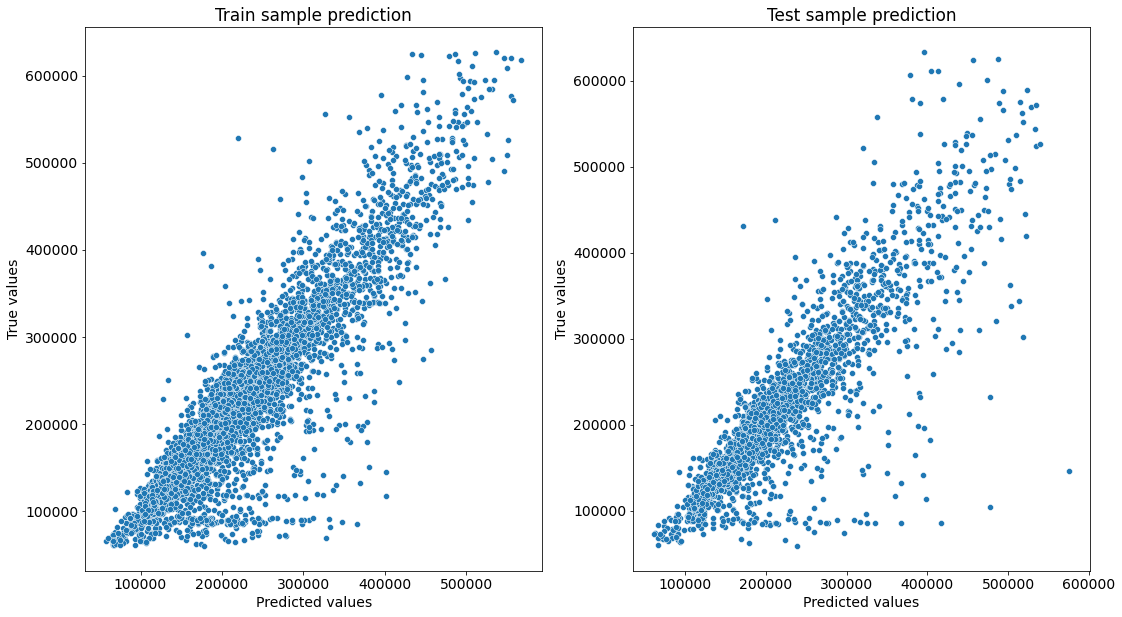

In [81]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

In [82]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.68094697, 0.7135518 , 0.76941152])

In [83]:
cv_score.mean()

0.721303432116596

#### Важность признаков

In [84]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.475028
16,DistrictSize,0.239862
11,Social_3,0.057440
10,Social_2,0.041060
7,Ecology_1,0.037750
0,Rooms,0.030211
19,MedPriceByYear,0.022464
5,HouseFloor,0.020192
9,Social_1,0.016038
6,HouseYear,0.014916


### 9. Прогнозирование на тестовом датасете<a class='anchor' id='test'>

In [85]:
test_df.shape

(5000, 20)

In [86]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,HouseFloor_outlier,DistrictSize,IsDistrictLarge,year_cat,MedPriceByYear
0,1.0,36.847630,19.094182,5.0,5.0,9.0,1970,0.036122,1,24,4378,0,1,1,1,0,76.0,0,2,182657.618386
1,1.0,42.493907,42.568133,10.0,7.0,17.0,2017,0.072158,1,2,629,1,0,0,0,0,169.0,1,5,177762.538836
2,2.0,59.463678,38.570943,9.0,19.0,19.0,1977,0.211401,1,9,1892,0,0,1,1,0,609.0,1,2,182657.618386
3,3.0,49.646030,33.893825,6.0,2.0,2.0,1965,0.014073,1,2,475,0,0,0,1,0,392.0,1,2,182657.618386
4,1.0,53.837056,37.069644,6.0,8.0,17.0,1977,0.309479,1,35,7715,4,0,6,1,0,68.0,0,2,182657.618386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,5.0,6.0,1962,0.069660,1,31,6119,4,1,2,1,1,59.0,0,2,182657.618386
4996,3.0,93.698122,94.521465,10.0,21.0,27.0,2018,0.060753,1,15,2787,2,0,7,1,0,26.0,0,5,177762.538836
4997,1.0,33.656723,19.003259,5.0,2.0,5.0,1966,0.038693,1,28,6533,1,2,5,1,0,57.0,0,2,182657.618386
4998,1.0,38.635155,20.976257,9.0,8.0,14.0,1970,0.089040,1,33,7976,5,0,11,1,0,42.0,0,2,182657.618386


In [87]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [88]:
predictions = gb_model.predict(test_df)
predictions

array([164390.38450203, 124513.84286727, 152643.09463656, ...,
       141518.05342216, 197374.02865552, 278050.15949286])

In [89]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,164390.384502
1,5925,124513.842867
2,960,152643.094637
3,3848,114891.354036
4,746,212913.167915


In [90]:
submit.to_csv('gb_submit.csv', index=False)